# TrenchRipper Master Notebook

#### Imports

In [ ]:
import trenchripper as tr

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider, Dropdown, IntText, SelectMultiple, IntRangeSlider, FloatRangeSlider
import ipywidgets as widgets
import matplotlib
import warnings
import copy

matplotlib.rcParams['figure.figsize'] = [20, 10]
warnings.filterwarnings(action='once')

#### Specify Paths

Begin by defining the directory in which all processing will be done, as well as the initial nd2 file we will be processing.

In [3]:
headpath = "/n/scratch2/de64/2019-05-31_validation_data"
nd2file = "/n/scratch2/de64/2019-05-31_validation_data/Main_Experiment.nd2"

#### Transfer files into the scratch folder

In [4]:
sourcedir = "/n/files/SysBio/PAULSSON\ LAB/Personal\ Folders/Daniel/Image_Data/Bacillus_Project/2019-05-31_DE85_training_data/exp_folder"
targetdir = "/n/scratch2/de64/2019-05-31_validation_data"
tr.trcluster.transferjob(sourcedir,targetdir)

<>:1: DeprecationWarning: invalid escape sequence \ 


## Extract to hdf5 files

#### Start Dask Workers

In [7]:
dask_controller = tr.trcluster.dask_controller(walltime='04:00:00',local=False,n_workers=10,memory='2GB',working_directory=headpath+"/dask")
dask_controller.startdask()

/home/de64/miniconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
/home/de64/miniconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:82: ResourceWarning: unclosed <socket.socket fd=145, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('0.0.0.0', 0)>
  raise


In [8]:
dask_controller.displaydashboard()

#### Perform Extraction

In [5]:
hdf5_extractor = tr.ndextract.hdf5_fov_extractor(nd2file,headpath,tpts_per_file=100,ignore_fovmetadata=False,nd2reader_override = {"z_levels":[],"z_coordinates":[]})

In [6]:
hdf5_extractor.inter_get_notes()

interactive(children=(Textarea(value='', description='Organism:', placeholder='Organism imaged in this experim…

In [9]:
hdf5_extractor.extract(dask_controller)

/home/de64/miniconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")
/home/de64/miniconda3/lib/python3.7/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (720045.2 ms) doesn't match the set interval (720000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)
/home/de64/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/de64/miniconda3/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is a Python keyword: 'global'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  ch

#### Shutdown Dask

In [25]:
dask_controller.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


## Kymographs

### Test Parameters

#### Initialize the interactive kymograph class

As a first step, initialize the `tr.interactive.kymograph_interactive` class that will be handling all steps of generating a kymograph. 

You will need to specify the following `args` and `kwargs` (in order):


**Args**

**input_file_prefix (string)** : File prefix for all input hdf5 files of the form "\[input_file_prefix\]\[number\].hdf5" This should be the default output format for the hdf5 export code, but you will need to rename files if taking input files from a different source.

**all_channels (list)** : list of strings corresponding to the different image channels available in the input hdf5 file, with the channel used for segmenting trenches in the first position. NOTE: these names must match those of the input hdf5 file datasets.

**fov_list (list)** : List of ints corresponding to the fovs that you wish to make kymographs of.

**Kwargs**

**t_subsample_step (int)** : Step size to be used for subsampling input files in time, recommend that subsampling results in between 5 and 20 timepoints for quick processing.

**t_range (tuple of ints)** : Range size to be used for subsampling input files in time.

The last line will perform import and subsampling of the input hdf5 image files.

In [3]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
interactive_kymograph = tr.kymograph_interactive(headpath)
channels,fov_list,timepoints_len = interactive_kymograph.get_image_params()

/home/de64/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/de64/TrenchRipper/trenchripper/utils.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [15]:
interact(interactive_kymograph.view_image,fov_idx=IntText(value=0,description='FOV number:',disabled=False),\
         t=IntSlider(value=0, min=0, max=timepoints_len-1, step=1,continuous_update=False),
        channel=Dropdown(options=channels,value=channels[0],description='Channel:',disabled=False),\
        invert=Dropdown(options=[True,False],value=False));

interactive(children=(IntText(value=0, description='FOV number:'), IntSlider(value=0, continuous_update=False,…

In [4]:
import_hdf5 = interactive(interactive_kymograph.import_hdf5_files, {"manual":True},all_channels=fixed(channels),seg_channel=Dropdown(options=channels,value=channels[0]),\
                          invert=Dropdown(options=[True,False],value=False),fov_list=SelectMultiple(options=fov_list),t_range=IntRangeSlider(value=[0, timepoints_len-1],\
                        min=0,max=timepoints_len-1,step=1,disabled=False,continuous_update=False),t_subsample_step=IntSlider(value=10, min=0, max=200, step=1));
display(import_hdf5)

interactive(children=(Dropdown(description='seg_channel', options=('Phase', 'GFP'), value='Phase'), Dropdown(d…

In [5]:
imported_array_list = copy.copy(import_hdf5.result)

#### Tune "trench-row" detection hyperparameters

The kymograph code begins by detecting the positions of trench rows in the image as follows:

1. Reducing each 2D image to a 1D signal along the y-axis by computing the qth percentile of the data along the x-axis
2. Smooth this signal using a median kernel
3. Use a [triangle threshold](https://imagej.net/Auto_Threshold#Triangle) to determine the trench row poisitons

This method uses the following `kwargs`, which you can tune here:

**y_percentile (int)** : Percentile to use for step 1.

**smoothing_kernel_y_dim_0 (int)** : Median kernel size to use for step 2.

**triangle_nbins (int)** : Number of bins to use in the triangle method histogram.

**triangle_scaling (float)** : Scaling factor to apply to the threshold determined by the triangle method.


Running the following widget will display the smoothed 1-D signal for each of your timepoints. In addition, the threshold value for each fov will be displayed as a red line.

In [6]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

row_detection = interactive(interactive_kymograph.preview_y_precentiles, {"manual":True},imported_array_list=fixed(imported_array_list),y_percentile=IntSlider(value=99, min=0, max=100, step=1),\
         smoothing_kernel_y_dim_0=IntSlider(value=29, min=1, max=200, step=2),triangle_nbins=IntSlider(value=50, min=10, max=300, step=10),\
                triangle_scaling=FloatSlider(value=3.5, min=0., max=4., step=0.05),\
            triangle_threshold_bounds=FloatRangeSlider(value=[0.1, 0.25],min=0,max=1.,step=0.01,disabled=False,continuous_update=False))
display(row_detection)

interactive(children=(IntSlider(value=99, description='y_percentile'), IntSlider(value=29, description='smooth…

#### Generate "trench-row" detection output

After determining your desired hyperparameters, set them in the next cell and run it to produce output for later steps. **Note: The thresholding parameters do not need to be specified at this point.**

In [11]:
y_percentiles_smoothed_list = copy.copy(row_detection.result)

#### Tune "trench-row" cropping hyperparameters

Next, we will use the detected rows to perform cropping of the input image in the y-dimension:

1. Determine edges of trench rows based on threshold mask.
2. Filter out rows that are too small.
3. Perform cropping using the "end" of the row as reference (the end referring to the part of the trench farthest from the feeding channel).

This method uses the following `kwargs`, which you can tune here:

**y_min_edge_dist (int)** : Minimum row length necessary for detection.

**padding_y (int)** : Padding to be used when cropping in the y-dimension.

**trench_len_y (int)** : Length from the end of the tenches to be used when cropping in the y-dimension.

**top_orientation (int)** : The orientation of the top-most row where 0 corresponds to a trench with a downward-oriented trench opening and 1 corresponds to a trench with an upward-oriented trench opening.

**vertical_spacing (float)** : Parameter for setting the distance of plots being viewed.

Running the following widget will display y-cropped images for each fov and timepoint.

In [12]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
y_cropping = interactive(interactive_kymograph.preview_y_crop,{"manual":True},y_percentiles_smoothed_list=fixed(y_percentiles_smoothed_list),\
                imported_array_list=fixed(imported_array_list),\
                y_min_edge_dist=IntSlider(value=50, min=10, max=200, step=10),\
                padding_y=IntSlider(value=20, min=0, max=100, step=1),\
                trench_len_y=IntSlider(value=270, min=0, max=1000, step=10),
               vertical_spacing=FloatSlider(value=0.9, min=0., max=2., step=0.01),\
                expected_num_rows=IntText(value=2,description='Number of Rows:',disabled=False),\
               orientation_detection=Dropdown(options=[0, 1, 'phase'],value=0,description='Orientation:',disabled=False),
                orientation_on_fail=Dropdown(options=[None,0, 1],value=0,description='Orientation when < expected rows:',disabled=False))
display(y_cropping)

interactive(children=(IntSlider(value=50, description='y_min_edge_dist', max=200, min=10, step=10), IntSlider(…

#### Generate "trench-row" cropping output

After determining your desired hyperparameters, set them in the next cell and run it to produce output for later steps.

In [13]:
cropped_in_y_list = copy.copy(y_cropping.result)

#### Tune trench detection hyperparameters

Next, we will detect the positions of trenchs in the y-cropped images as follows:

1. Reducing each 2D image to a 1D signal along the x-axis by computing the qth percentile of the data along the y-axis.
2. Determine the signal background by smooth this signal using a large median kernel.
3. Subtract the background signal.
4. Smooth the resultant signal using a median kernel.
5. Use a [otsu threhsold](https://imagej.net/Auto_Threshold#Otsu) to determine the trench midpoint poisitons.

This method uses the following `kwargs`, which you can tune here:

**x_percentile (int)** : Percentile to use for step 1.

**background_kernel_x (int)** : Median kernel size to use for step 2.

**smoothing_kernel_x (int)** : Median kernel size to use for step 4.

**otsu_nbins (int)** : Number of bins to use in the Otsu's method histogram.

**otsu_scaling (float)** : Scaling factor to apply to the threshold determined by Otsu's method.

**vertical_spacing (float)** : Parameter for setting the distance of plots being viewed.

Running the following widget will display the smoothed 1-D signal for each of your timepoints. In addition, the threshold value for each fov will be displayed as a red line.

In [14]:
trench_detection = interactive(interactive_kymograph.preview_x_percentiles, {"manual":True}, cropped_in_y_list=fixed(cropped_in_y_list),t=IntSlider(value=0, min=0, max=cropped_in_y_list[0].shape[4]-1, step=1),\
                x_percentile=IntSlider(value=85, min=50, max=100, step=1),background_kernel_x=IntSlider(value=21, min=1, max=601, step=20), smoothing_kernel_x=IntSlider(value=9, min=1, max=31, step=2),\
               otsu_nbins=IntSlider(value=50, min=10, max=200, step=10),otsu_scaling=FloatSlider(value=0.25, min=0., max=2., step=0.01),\
               vertical_spacing=FloatSlider(value=0.9, min=0., max=2., step=0.01));
display(trench_detection)

interactive(children=(IntSlider(value=0, description='t', max=7), IntSlider(value=85, description='x_percentil…

#### Generate trench detection output

After determining your desired hyperparameters, set them in the next cell and run it to produce output for later steps. **Note: The thresholding parameters do not need to be specified at this point.**

In [15]:
smoothed_x_percentiles_list = trench_detection.result

#### Check midpoint drift

Next, we will perform x-dimension drift correction of our detected midpoints as follows:

1. Begin at t=1
2. For $m \in \{midpoints(t)\}$ assign $n \in \{midpoints(t-1)\}$ to m if n is the closest midpoint to m at time $t-1$,
points that are not the closest midpoint to any midpoints in m will not be mapped.
3. Compute the translation of each midpoint at time.
4. Take the average of this value as the x-dimension drift from time t-1 to t.

This method uses the following `kwargs`, which you can tune here:

**vertical_spacing (float)** : Parameter for setting the distance of plots being viewed.

Running the following widget will display the detected midpoints for each of your timepoints. If there is too much sparsity, or discontinuity, your drift correction will not be accurate.

In [16]:
midpoint_drift = interactive(interactive_kymograph.preview_midpoints,{"manual":True},smoothed_x_percentiles_list=fixed(smoothed_x_percentiles_list),\
               vertical_spacing=FloatSlider(value=0.8, min=0., max=2., step=0.01));
display(midpoint_drift)

interactive(children=(FloatSlider(value=0.8, description='vertical_spacing', max=2.0, step=0.01), Button(descr…

#### Generate midpoint drift output

After determining your desired hyperparameters, set them in the next cell and run it to produce output for later steps.

In [17]:
all_midpoints_list,x_drift_list = midpoint_drift.result

#### Tune trench cropping hyperparameters

Trench cropping simply uses the drift-corrected midpoints as a reference and crops out some fixed length around them to produce an output kymograph

This method uses the following `kwargs`, which you can tune here:

**trench_width_x (int)** : Trench width to use for cropping.

**vertical_spacing (float)** : Parameter for setting the distance of plots being viewed.

Running the following widget will display a random kymograph for each row in each fov.

It will also produce midpoint plots showing retained midpoints

In [18]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
interact_manual(interactive_kymograph.preview_kymographs,cropped_in_y_list=fixed(cropped_in_y_list),all_midpoints_list=fixed(all_midpoints_list),\
                x_drift_list=fixed(x_drift_list),trench_width_x=IntSlider(value=30, min=10, max=50, step=2),\
                trench_present_thr=FloatSlider(value=0., min=0., max=1., step=0.05),\
               vertical_spacing=FloatSlider(value=0.8, min=0., max=2., step=0.01))

interactive(children=(IntSlider(value=30, description='trench_width_x', max=50, min=10, step=2), FloatSlider(v…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

#### Export and save hyperparameters

In [19]:
interactive_kymograph.process_results()

Y Percentile 99
Y Smoothing Kernel 53
Triangle Threshold Bins 50
Triangle Threshold Scaling 0.0
Triangle Max Threshold 0.5
Triangle Min Threshold 0.35
Minimum Trench Length 100
Y Padding 20
Trench Length 270
Orientation Detection Method 0
Expected Number of Rows (Manual Orientation Detection) 2
Top Orientation when Row Drifts Out (Manual Orientation Detection) 0
X Percentile 90
X Background Kernel 61
X Smoothing Kernel 9
Otsu Threshold Bins 50
Otsu Threshold Scaling 0.25
Trench Width 22
Trench Presence Threshold 0.8
All Channels ['GFP', 'Phase']
Time Range (0, 71)
Invert False


In [20]:
interactive_kymograph.write_param_file()

### Generate Kymograph

#### Start Dask Workers

In [21]:
dask_controller = tr.trcluster.dask_controller(walltime='04:00:00',local=False,n_workers=100,memory='8GB',\
                                            working_directory="/n/scratch2/de64/2019-11-09_CN_Growth_Curve/")
dask_controller.startdask()

/home/de64/miniconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
/home/de64/miniconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:82: ResourceWarning: unclosed <socket.socket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('0.0.0.0', 0)>
  raise


In [22]:
dask_controller.displaydashboard()

In [23]:
kymoclust = tr.kymograph.kymograph_cluster(headpath=headpath,trenches_per_file=25,paramfile=True)

In [24]:
kymoclust.generate_kymographs(dask_controller)

/home/de64/TrenchRipper/trenchripper/utils.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [25]:
kymoclust.post_process(dask_controller)

#### Check kymograph statistics

In [26]:
kymoclust.kymo_report()

fovs processed: 36/40
lanes processed: 68
trenches processed: 3632
row/fov: 1.8888888888888888
trenches/fov: 100.88888888888889
failed fovs: [0, 2, 4, 13]


#### Shutdown Dask

In [27]:
dask_controller.shutdown()

## Fluorescence Segmentation

### Test Parameters

#### Initialize the interactive segmentation class

As a first step, initialize the `tr.interactive.fluo_segmentation_interactive` class that will be handling all steps of generating a segmentation. 

You will need to specify the following `args` (in order):


**Args**

**headpath (string)** : Top level path being used for processing (same as the rest of the mother machine pipeline.)

In [5]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
interactive_segmentation = tr.fluo_segmentation_interactive(headpath)

/home/de64/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/de64/TrenchRipper/trenchripper/utils.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


#### Choose channel to segment on

In [6]:
choose_channel = interactive(interactive_segmentation.choose_seg_channel, {"manual":True},seg_channel=Dropdown(options=interactive_segmentation.all_channels,\
                                                                                              value=interactive_segmentation.all_channels[0]));
display(choose_channel)

interactive(children=(Dropdown(description='seg_channel', options=('Phase', 'GFP'), value='Phase'), Button(des…

#### Import data

Fill in 

You will need to tune the following `args` and `kwargs` (in order):

**fov_idx (int)** :

**n_trenches (int)** :

**t_range (tuple)** :

**t_subsample_step (int)** :

In [7]:
kymo_arr_int = interactive(interactive_segmentation.import_array, {"manual":True},\
                       n_trenches=IntText(value=12,description='Number of trenches:',disabled=False),\
                       t_range=IntRangeSlider(value=[interactive_segmentation.t_range[0],interactive_segmentation.t_range[1]-1],\
                        description='Time Range:',min=interactive_segmentation.t_range[0],max=interactive_segmentation.t_range[1]-1,step=1,disabled=False),\
                       t_subsample_step=IntSlider(value=1,description='Time Subsampling Step:', min=1, max=20, step=1),\
                       fig_size_y=IntSlider(value=20, description='Figure Size (Y Dimension):' , min=1, max=30, step=1),\
                       fig_size_x=IntSlider(value=12, description='Figure Size (X Dimension):', min=1, max=30, step=1),\
                          img_per_row=IntSlider(value=6, description='Images per Row:', min=1, max=30, step=1));
display(kymo_arr_int)

interactive(children=(IntText(value=12, description='Number of trenches:'), IntRangeSlider(value=(0, 70), desc…

In [9]:
kymo_arr = copy.copy(kymo_arr_int.result)

#### Scale data

Fill in 

You will need to tune the following `args` and `kwargs` (in order):

**scale (bool)** : Whether to scale the kymograph in time.

**scaling_percentile (int)** : Whole image intensity percentile to use to determine scaling constant. 

#### Apply Gaussian Filter

Fill in 

You will need to tune the following `args` and `kwargs` (in order):

**smooth_sigma (float)** : Standard deviation of gaussian kernel.

In [10]:
proc_list_int = interactive(interactive_segmentation.plot_processed, {"manual":True},kymo_arr=fixed(kymo_arr),\
                          smooth_sigma=FloatSlider(value=0.75,description='Gaussian Kernel Sigma:',min=0.,max=3.,step=0.25,disabled=False),\
                          bit_max=IntSlider(value=1000,description='8-bit Maximum:',min=0,max=65535,step=250,disabled=False),\
                          scale=Dropdown(options=[True,False],value=True,description='Scale Fluorescence?',disabled=False),\
                          scaling_percentile=IntSlider(value=90,description='Scaling Percentile:',min=0,max=100,step=1,disabled=False));

display(proc_list_int)

interactive(children=(FloatSlider(value=0.75, description='Gaussian Kernel Sigma:', max=3.0, step=0.25), IntSl…

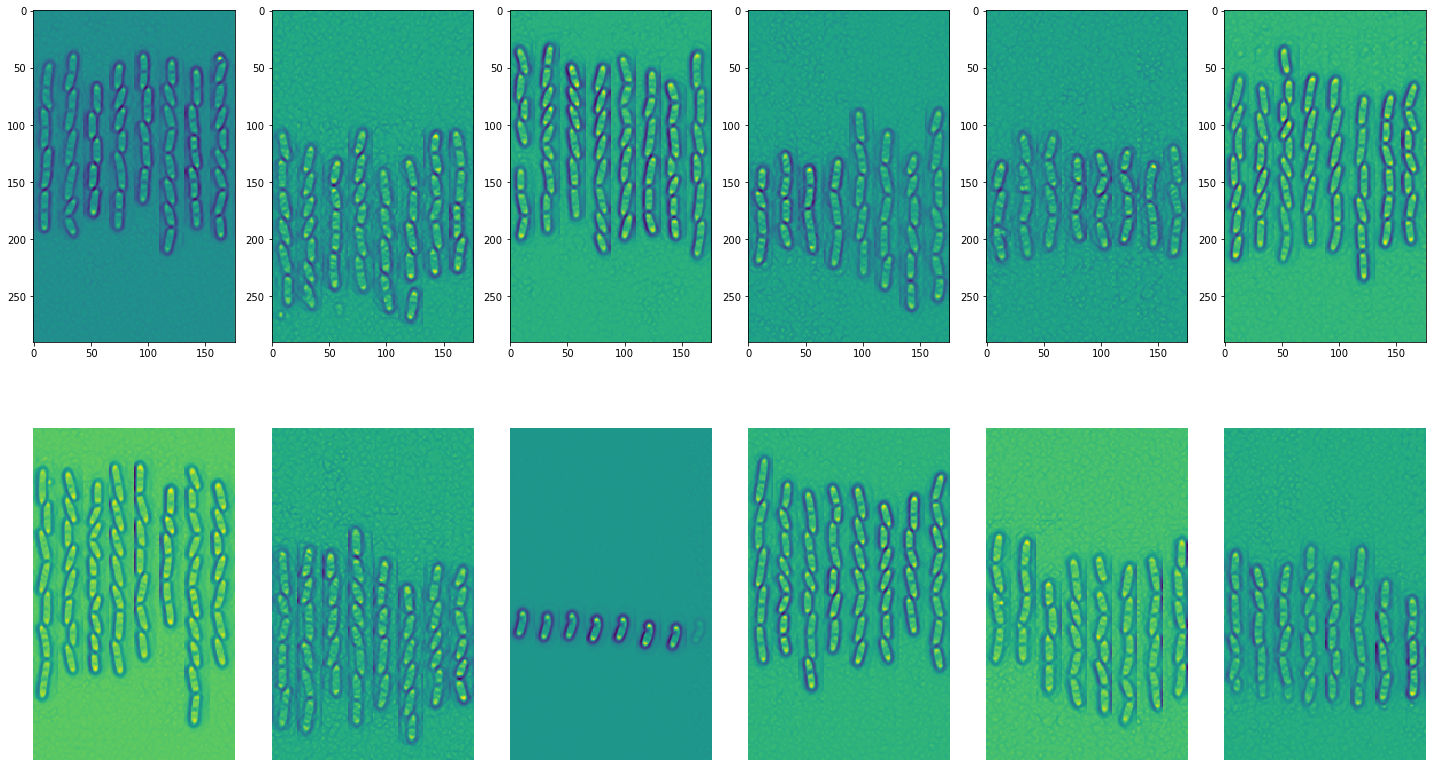

In [11]:
proc_list = copy.copy(proc_list_int.result)
eigval_list = interactive_segmentation.plot_eigval(proc_list)

#### Determine Cell Mask Envelope

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**cell_mask_method (str)** : Thresholding method, can be a local or global Otsu threshold.

**cell_otsu_scaling (float)** : Scaling factor applied to determined threshold.

**local_otsu_r (int)** : Radius of thresholding kernel used in the local otsu thresholding.

In [12]:
cell_mask_list_int = interactive(interactive_segmentation.plot_cell_mask, {"manual":True},proc_list=fixed(proc_list),\
                          cell_mask_method=Dropdown(options=['local','global'],value='local',description='Cell Mask Thresholding Method:',disabled=False),\
                          global_threshold=IntSlider(value=50,description='Global Threshold:',min=0,max=255,step=1,disabled=False),\
                          cell_otsu_scaling=FloatSlider(value=0.95,description='Cell Threshold Scaling:',min=0.,max=2.,step=0.01,disabled=False),\
                          local_otsu_r=IntSlider(value=15,description='Local Otsu Radius:',min=0,max=30,step=1,disabled=False));
display(cell_mask_list_int)

interactive(children=(IntSlider(value=50, description='Global Threshold:', max=255), Dropdown(description='Cel…

In [37]:
cell_mask_list = copy.copy(cell_mask_list_int.result)

#### Display Edge Mask at Threshold Value

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**edge_threshold_scaling (float)** : Scaling factor applied to determined threshold.

In [38]:
composite_mask_list_int = interactive(interactive_segmentation.plot_threshold_result, {"manual":True},eigval_list=fixed(eigval_list),cell_mask_list=fixed(cell_mask_list),\
                          edge_threshold_scaling=FloatSlider(value=1.,description='Edge Threshold Scaling',min=0.,max=2.,step=0.01,disabled=False),\
                          min_obj_size=IntSlider(value=30,description='Minimum Object Size:',min=0,max=100,step=2,disabled=False));
display(composite_mask_list_int)

interactive(children=(FloatSlider(value=1.0, description='Edge Threshold Scaling', max=2.0, step=0.01), IntSli…

#### Threshold Sampling and Convexity Calculation

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**edge_threshold_scaling (float)** : Scaling factor applied to determined threshold.

**threshold_step_perc (float)** : Threshold step size to be used for trying multiple thresholds.

**threshold_perc_num_steps (int)** : Number of steps to use when generating multiple thresholds.

In [39]:
conv_scores_list_int = interactive(interactive_segmentation.plot_scores, {"manual":True},eigval_list=fixed(eigval_list),cell_mask_list=fixed(cell_mask_list),\
                          edge_threshold_scaling=FloatSlider(value=0.9,description='Edge Threshold Scaling',min=0.,max=2.,step=0.01,disabled=False),\
                          threshold_step_perc=FloatSlider(value=0.05,description='Threshold Step Percent',min=0.,max=0.5,step=0.01,disabled=False),\
                          threshold_perc_num_steps=IntSlider(value=2,description='Number of Threshold Steps',min=0,max=5,step=1,disabled=False),\
                          min_obj_size=IntSlider(value=30,description='Minimum Object Size:',min=0,max=100,step=2,disabled=False));
display(conv_scores_list_int)

interactive(children=(FloatSlider(value=0.9, description='Edge Threshold Scaling', max=2.0, step=0.01), FloatS…

In [40]:
conv_scores_list = copy.copy(conv_scores_list_int.result)

#### Convexity Thresholding

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**convex_threshold (float)** : Threshold to be used for convexity thresholding.

In [41]:
final_mask_list_int = interactive(interactive_segmentation.plot_final_mask, {"manual":True},conv_scores_list=fixed(conv_scores_list),\
                          convex_threshold=FloatSlider(value=0.75,description='Convexity Threshold:',min=0.,max=1.,step=0.01,disabled=False));
display(final_mask_list_int)

interactive(children=(FloatSlider(value=0.75, description='Convexity Threshold:', max=1.0, step=0.01), Button(…

In [42]:
interactive_segmentation.process_results()

Gaussian Kernel Sigma: 1.0
8 Bit Maximum: 2000
Scale Fluorescence? False
Scaling Percentile: 90
Cell Mask Thresholding Method: local
Global Threshold: 40
Cell Threshold Scaling: 0.95
Local Otsu Radius: 15
Edge Threshold Scaling: 0.7
Threshold Step Percent: 0.2
Number of Threshold Steps: 3
Minimum Object Size: 30
Convexity Threshold: 0.8
Segmentation Channel: GFP


In [43]:
interactive_segmentation.write_param_file()

### Generate Segmentation

#### Start Dask Workers

In [13]:
dask_controller = tr.trcluster.dask_controller(walltime='01:00:00',local=False,n_workers=200,memory='1GB',working_directory=headpath+"/dask")
dask_controller.startdask()

/home/de64/miniconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
/home/de64/miniconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:82: ResourceWarning: unclosed <socket.socket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('0.0.0.0', 0)>
  raise


AttributeError: 'SLURMCluster' object has no attribute 'start_workers'

In [14]:
dask_controller.displaydashboard()

In [15]:
segment = tr.segment.fluo_segmentation_cluster(headpath,paramfile=True)

In [16]:
segment.dask_segment(dask_controller)

/home/de64/TrenchRipper/trenchripper/utils.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


#### Stop Dask Workers

In [84]:
dask_controller.shutdown()

distributed.client - ERROR - Restart timed out after 6.000000 seconds


## Lineage Tracing

### Test Parameters

In [17]:
score_function = tr.tracking.scorefn(headpath,"fluorsegmentation",u_size=0.22,sig_size=0.08,u_pos=0.21,sig_pos=0.1,w_merge=0.8)

In [18]:
score_function.interactive_scorefn()

interactive(children=(IntSlider(value=0, description='trenchid', max=3631), IntRangeSlider(value=(0, 70), cont…

In [19]:
Tracking_Solver = tr.tracking.tracking_solver(headpath,"fluorsegmentation",ScoreFn=score_function,merge_per_iter=0,conv_tolerence=2,edge_limit=2)
data,orientation,empty_trenches = score_function.output.result

/home/de64/TrenchRipper/trenchripper/utils.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [20]:
Tracking_Solver.interactive_tracking(data,orientation)

interactive(children=(SelectMultiple(description='intensity_channel_list', options=('Phase', 'GFP'), value=())…

In [21]:
Tracking_Solver.save_params()

Channels: ['Phase', 'GFP']
Merges Detected Per Iteration: 0
# Unimproved Iterations Before Stopping: 2
Closest N Objects to Consider: 2
Mean Size Increase: 0.22
Standard Deviation of Size Increase: 0.08
Mean Position Increase: 0.21
Standard Deviation of Position Increase: 0.1
Cell Merging Weight: 0.8


### Generate Lineage Traces

In [4]:
dask_controller = tr.trcluster.dask_controller(walltime='01:00:00',local=False,n_workers=100,memory='2GB',working_directory=headpath+"/dask")
dask_controller.startdask()

/home/de64/miniconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
/home/de64/miniconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:82: ResourceWarning: unclosed <socket.socket fd=48, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('0.0.0.0', 0)>
  raise


In [5]:
dask_controller.displaydashboard()

In [6]:
Tracking_Solver = tr.tracking.tracking_solver(headpath,"fluorsegmentation",paramfile=True)

/home/de64/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/de64/TrenchRipper/trenchripper/utils.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [7]:
Tracking_Solver.compute_all_lineages(dask_controller)

In [8]:
dask_controller.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


## Region Properties (No Lineage)

In [ ]:
analyzer = tr.analysis.regionprops_extractor(headpath,"fluorsegmentation",intensity_channel_list=["mCherry","YFP"])

In [4]:
analyzer.export_all_data()

/home/de64/anaconda3/lib/python3.7/site-packages/bokeh/plotting/helpers.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, OrderedDict, Sequence


/home/de64/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
Worker tcp://10.120.16.238:42733 restart in Job 2026383. This can be due to memory issue.
Worker tcp://10.120.17.9:38043 restart in Job 2026390. This can be due to memory issue.
Worker tcp://10.120.17.9:56610 restart in Job 2026391. This can be due to memory issue.
Worker tcp://10.120.16.169:47631 restart in Job 2026385. This can be due to memory issue.
Worker tcp://10.120.16.169:46795 restart in Job 2026384. This can be due to memory issue.
Worker tcp://10.120.16.193:44803 restart in Job 2026389. This can be due to memory issue.
Worker tcp://10.120.16.171:59721 restart in Job 2026382. This can be due to memory issue.
Worker tcp://10.120.16.192:54068 restart in Job 2026388. This can be due to memory issue.
Worker tcp://10.120.17.12:45454 restart in Job 2026392. This can be due to memory issue.


## Inspect Kymographs

In [43]:
%matplotlib widget

kyview = tr.analysis.kymograph_viewer(headpath,"mCherry","fluorsegmentation")

In [44]:
kyviewer = interactive(kyview.inspect_trench, {"manual":True},file_idx=IntText(value=0,description='File Index:',disabled=False),\
                       trench_idx=IntText(value=0,description='Trench Index:',disabled=False),\
                        x_size=IntSlider(value=20,description='X Size:',min=0,max=50,step=1,disabled=False),\
                      y_size=IntSlider(value=6,description='Y Size:',min=0,max=30,step=1,disabled=False));
display(kyviewer)

interactive(children=(IntText(value=0, description='File Index:'), IntText(value=0, description='Trench Index:…

In [ ]:
interact(interactive_kymograph.view_image,fov_idx=IntText(value=0,description='FOV number:',disabled=False),\
         t=IntSlider(value=0, min=0, max=timepoints_len-1, step=1,continuous_update=False),
        channel=Dropdown(options=channels,value=channels[0],description='Channel:',disabled=False),\
        invert=Dropdown(options=[True,False],value=False));

## Phase Segmentation Training

### Data Preparation

In [2]:
dataloader = tr.unet.UNet_Training_DataLoader(nndatapath="/n/scratch2/de64/nntest7",experimentname="First NN",trainpath="/n/scratch2/de64/2019-06-18_DE85_training_data",\
                                      testpath="/n/scratch2/de64/2019-05-31_validation_data",\
                                      valpath="/n/scratch2/de64/2019-05-31_validation_data")

In [40]:
dataloader = tr.unet.UNet_Training_DataLoader(nndatapath="/n/scratch2/de64/nntest8",experimentname="First NN",trainpath="/n/scratch2/de64/2019-05-31_validation_data",\
                                      testpath="/n/scratch2/de64/2019-06-18_DE85_training_data",\
                                      valpath="/n/scratch2/de64/2019-06-18_DE85_training_data")

In [80]:
dataloader = tr.unet.UNet_Training_DataLoader(nndatapath="/n/scratch2/de64/nntest9",experimentname="First NN",trainpath="/n/scratch2/de64/2019-05-31_validation_data",\
                                      testpath="/n/scratch2/de64/2019-06-18_DE85_training_data",\
                                      valpath="/n/scratch2/de64/2019-06-18_DE85_training_data")

In [190]:
dataloader = tr.unet.UNet_Training_DataLoader(nndatapath="/n/scratch2/de64/nntest10",experimentname="First NN",trainpath="/n/scratch2/de64/2019-06-18_DE85_training_data",\
                                      testpath="/n/scratch2/de64/2019-05-31_validation_data",\
                                      valpath="/n/scratch2/de64/2019-05-31_validation_data")

#### Training Set Selection

In [191]:
dataloader.inter_get_selection(dataloader.trainpath,"train")

/home/de64/TrenchRipper/trenchripper/utils.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


interactive(children=(Dropdown(description='Feature Channel:', options=('Phase', 'GFP'), value='Phase'), Selec…

#### Test Set Selection

In [192]:
dataloader.inter_get_selection(dataloader.testpath,"test")

interactive(children=(Dropdown(description='Feature Channel:', options=('Phase', 'GFP'), value='Phase'), Selec…

#### Validation Set Selection

In [193]:
dataloader.inter_get_selection(dataloader.valpath,"val")

interactive(children=(Dropdown(description='Feature Channel:', options=('Phase', 'GFP'), value='Phase'), Selec…

#### Weightmap Parameters

In [194]:
dataloader.display_grid()

In [195]:
dataloader.get_grid_params()

======== Grid Params ========
W0 (Border Region Weight): (5.0, 10.0)
Wm Sigma (Border Region Spread): (4.0, 5.0)


#### Export

In [196]:
dataloader.export_all_data(memory="6GB")

/home/de64/TrenchRipper/trenchripper/utils.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata
Worker tcp://10.120.17.9:49469 restart in Job 52765093. This can be due to memory issue.
Worker tcp://10.120.17.9:45366 restart in Job 52765092. This can be due to memory issue.
Worker tcp://10.120.17.9:54329 restart in Job 52765094. This can be due to memory issue.
Worker tcp://10.120.17.9:52246 restart in Job 52765095. This can be due to memory issue.
Worker tcp://10.120.16.190:43141 restart in Job 52765088. This can be due to memory issue.
Worker tcp://10.120.16.191:60907 restart in Job 52765089. This can be due to memory issue.
Worker tcp://10.120.17.11:39554 restart in Job 52765099. This can be due to memory issue.
Worker tcp://10.120.17.12:45024 restart in Job 52765096. This can be due to memory issue.
Worker tcp://10.

### Hyperparameter (Grid) Search

#### Set-up Search

In [197]:
grid = tr.unet.GridSearch("/n/scratch2/de64/nntest10",numepochs=15)

In [198]:
grid.display_grid()

/home/de64/TrenchRipper/trenchripper/utils.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [199]:
grid.get_grid_params()

======== Grid Params ========
Batch Size: (10,)
Layers: (3,)
Hidden Size: (32,)
Learning Rate: (0.005,)
Momentum: (0.99,)
Weight Decay: (0.0005,)
Dropout: (0.7,)
w0: (5.0, 10.0)
wm sigma (4.0, 5.0)


#### Run Search

In [200]:
grid.run_grid_search(gres='gpu:teslaK80:1')

#### Evaluate Results

In [158]:
%matplotlib ipympl
matplotlib.rcParams['figure.figsize'] = [12, 8]

import seaborn as sns; sns.set()
sns.set(font_scale=2)

In [345]:
vis = tr.unet.TrainingVisualizer("/n/scratch2/de64/nntest10","/n/groups/paulsson/Daniel/NNModels")

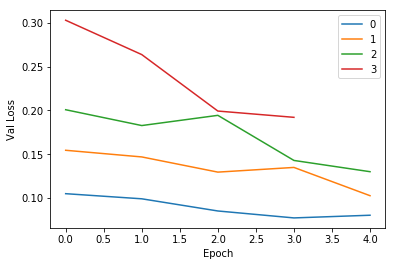

In [346]:
vis.inter_plot_loss("Val Loss")
vis.grid_widget.on('filter_changed', vis.handle_filter_changed)

In [347]:
vis.grid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [184]:
vis.inter_df_columns()

interactive(children=(SelectMultiple(description='Columns to Display:', options=('Train Dataset', 'Train Organ…

In [185]:
vis.model_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

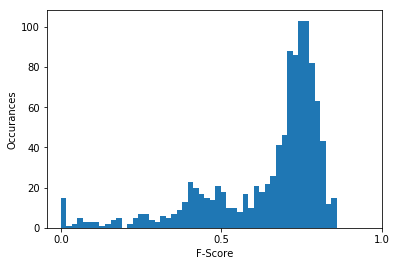

In [187]:
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

plt.hist(vis.model_df["Val F1 Cell Scores"][0],bins=50)
plt.xlabel("F-Score")
plt.ylabel("Occurances")
plt.xticks(np.arange(0, 1.01, step=0.5))
plt.draw()

In [4]:
headpath = "/n/scratch2/de64/2019-07-08_bacillus_rodz_mut_expt_bmbm_ti4"
unetseg = tr.unet.UNet_Segmenter(headpath, "Phase", "/n/groups/paulsson/Daniel/NNModels", min_obj_size=20)

In [ ]:
choose_channel = interactive(unetseg.choose_seg_channel, {"manual":True},seg_channel=Dropdown(options=unetseg.all_channels,\
                                                                                              value=unetseg.all_channels[0]));
display(choose_channel)

In [7]:
unetseg.inter_df_columns()

AttributeError: 'UNet_Segmenter' object has no attribute 'models_df'

In [201]:
import torch
import numpy as np
import h5py
import trenchripper as tr
from matplotlib import pyplot as plt

In [303]:
with h5py.File("/n/scratch2/de64/nntest7/test.hdf5","r") as infile:
    img_arr = torch.Tensor(infile["img"][535:550])
    seg_arr = torch.Tensor(infile["seg"][100:200:10])
    weight_arr = infile['weight_(10.0, 4.0)'][0:300:10]

In [304]:
testunet = tr.unet.UNet(1,2,layers=3,hidden_size=32,dropout=0.,withsoftmax=True)
device = torch.device('cpu')
testunet.load_state_dict(torch.load("/n/scratch2/de64/nntest7/models/0.pt",map_location=device))

<All keys matched successfully>

In [305]:
y = testunet.forward(img_arr).detach().numpy()[:,1]
x = img_arr.detach().numpy().squeeze(1)

In [306]:
x.shape

(15, 180, 22)

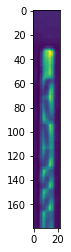

In [307]:
plt.imshow(x[4])

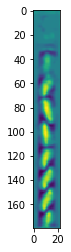

In [308]:
plt.imshow(y[4])

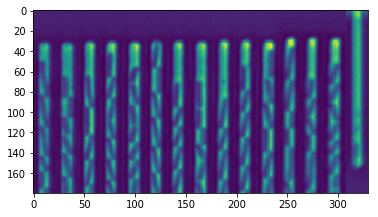

In [309]:
img_kymo = tr.utils.kymo_handle()
img_kymo.import_wrap(x)
img = img_kymo.return_unwrap(padding=0)
plt.imshow(img)

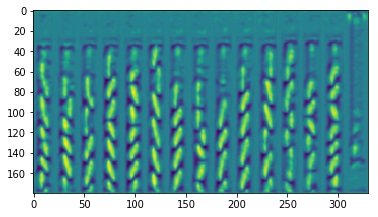

In [310]:
seg_kymo = tr.utils.kymo_handle()
seg_kymo.import_wrap(y)
seg = seg_kymo.return_unwrap(padding=0)
plt.imshow(seg)

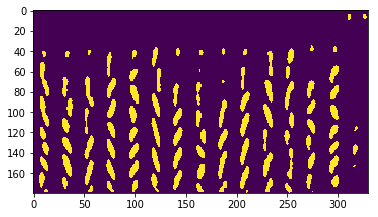

In [341]:
mask = seg>0.6
plt.imshow(mask)

In [342]:
import skimage as sk

In [343]:
filtered_mask = sk.morphology.remove_small_objects(mask,min_size=30)

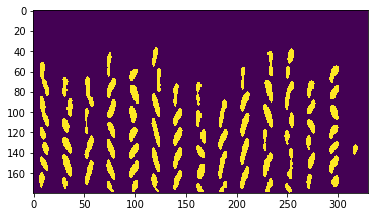

In [344]:
plt.imshow(filtered_mask)

## Other

#### Dask Utilities

In [103]:
dask_controller.shutdown()

Worker tcp://10.120.17.98:56665 restart in Job 61264349. This can be due to memory issue.
Worker tcp://10.120.17.58:56798 restart in Job 61264335. This can be due to memory issue.
Worker tcp://10.120.17.58:33473 restart in Job 61264334. This can be due to memory issue.
Worker tcp://10.120.16.238:33189 restart in Job 61264360. This can be due to memory issue.
Worker tcp://10.120.16.64:53891 restart in Job 61264318. This can be due to memory issue.
Worker tcp://10.120.16.51:47816 restart in Job 61264317. This can be due to memory issue.
Worker tcp://10.120.17.112:51530 restart in Job 61264327. This can be due to memory issue.
Worker tcp://10.120.16.244:59892 restart in Job 61264314. This can be due to memory issue.
Worker tcp://10.120.16.186:38011 restart in Job 61264291. This can be due to memory issue.
Worker tcp://10.120.16.186:59989 restart in Job 61264363. This can be due to memory issue.
Worker tcp://10.120.16.186:56494 restart in Job 61264362. This can be due to memory issue.
Work

In [17]:
dask_controller.retry_failed()

Worker tcp://10.120.16.117:43008 restart in Job 43139620. This can be due to memory issue.
Worker tcp://10.120.17.99:46159 restart in Job 43139597. This can be due to memory issue.
Worker tcp://10.120.17.99:47339 restart in Job 43139596. This can be due to memory issue.
Worker tcp://10.120.16.54:36220 restart in Job 43139615. This can be due to memory issue.
Worker tcp://10.120.17.112:51330 restart in Job 43139598. This can be due to memory issue.
Worker tcp://10.120.16.49:52635 restart in Job 43139590. This can be due to memory issue.
Worker tcp://10.120.17.129:42849 restart in Job 43139600. This can be due to memory issue.
Worker tcp://10.120.17.129:52698 restart in Job 43139601. This can be due to memory issue.
Worker tcp://10.120.17.120:34163 restart in Job 43139608. This can be due to memory issue.
Worker tcp://10.120.17.120:49615 restart in Job 43139609. This can be due to memory issue.
Worker tcp://10.120.16.135:51837 restart in Job 43139621. This can be due to memory issue.
Wor

In [69]:
dask_controller.daskclient.restart()

Client Scheduler: tcp://10.120.16.188:55108 Dashboard: http://10.120.16.188:8787/status,Cluster Workers: 101 Cores: 101 Memory: 808.00 GB


In [13]:
dask_controller.retry_processing()